A typical work-flow in the Python part of the framework is as follows:
\begin{itemize}
\item Load json with control flow graph into a \texttt{Module} object
\item Perform necessary data-flow analysis
\item Execute the chosen register allocation algorithm(s)
\item Test and compare results
\end{itemize}

Below we show an example of interactive, step-by-step register allocation based on basic version of Linear Scan algorithm. At the end we present the usage of full end-to-end allocation procedure and compare the basic version of the algorithm with the Extended Linear Scan. As an input we will use a simple program computing greatest common divisor.

## Loading programs from json and data flow analysis.
We assume to already have a json file with the Control Flow Graph of our program, generated by the LLVM plugin. It can be now loaded into a \texttt{Module} object which will give us access to all the functions in the file. Here, we only have two functions: \texttt{gcd} and \texttt{main}. We will focus on the first.

Having loaded the file, we perform full data flow analysis on our \texttt{Module} including liveness, dominance and loop analysis which is everything we need for register allocation.

At the end we print out the function to the output.

In [1]:
import cfg
import cfg.analysis as analysis
from cfg.printer import FunctionString

m = cfg.Module.from_file("programs/gcd.json")
analysis.perform_full_analysis(m)

print "Functions in the module: ", ", ".join(m.functions.keys()), "\n"

gcd = m.functions['gcd']
print FunctionString(gcd)

Functions in the module:  main, gcd 

bb1(entry)
  0:   v1 = icmp v2 v3               
  1:   v4 = br v1 bb3 bb2          


bb2(if.then)
  2:   v5 = xor v2 v3               
  3:   v6 = xor v3 v5               
  4:   v7 = xor v5 v6               
  5:   v8 = br bb3                 


bb3(if.end)
  6:   v9 = phi bb2 -> v6 bb1 -> v3 
  7:  v10 = phi bb2 -> v7 bb1 -> v2 
  8:  v11 = br bb4                 


bb4(while.cond)
  9:  v12 = phi bb5 -> v13 bb3 -> v9 
 10:  v14 = phi bb5 -> v12 bb3 -> v10 
 11:  v15 = icmp v12 const           
 12:  v16 = br v15 bb6 bb5         


bb5(while.body)
 13:  v13 = srem v14 v12             
 14:  v17 = br bb4                 


bb6(while.end)
 15:  v18 = ret v14                 




The \texttt{cfg.printer} module contains helper classes for printing various objects we operate on, such as \texttt{FunctionString}, \texttt{BBString} or \texttt{InstructionString}. When using any of them, we can pass options saying what we want to include in the object description. Here, apart from the sole function body, we can print predecessors, successors, liveness sets, dominance sets and so on.

In [2]:
from cfg.printer import Opts
print FunctionString(gcd, Opts(predecessors=True, successors=True, 
                               liveness=True, dominance=True))

bb1(entry)
  0:   v1 = icmp v2 v3               
  1:   v4 = br v1 bb3 bb2          
     PREDS: []
     SUCCS: [bb3, bb2]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v2, v3]
       DOM: [bb1]


bb2(if.then)
  2:   v5 = xor v2 v3               
  3:   v6 = xor v3 v5               
  4:   v7 = xor v5 v6               
  5:   v8 = br bb3                 
     PREDS: [bb1]
     SUCCS: [bb3]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v6, v7]
       DOM: [bb1, bb2]


bb3(if.end)
  6:   v9 = phi bb2 -> v6 bb1 -> v3 
  7:  v10 = phi bb2 -> v7 bb1 -> v2 
  8:  v11 = br bb4                 
     PREDS: [bb2, bb1]
     SUCCS: [bb4]
   LIVE-IN: [v9, v10]
  LIVE-OUT: [v9, v10]
       DOM: [bb1, bb3]


bb4(while.cond)
  9:  v12 = phi bb5 -> v13 bb3 -> v9 
 10:  v14 = phi bb5 -> v12 bb3 -> v10 
 11:  v15 = icmp v12 const           
 12:  v16 = br v15 bb6 bb5         
     PREDS: [bb5, bb3]
     SUCCS: [bb6, bb5]
   LIVE-IN: [v12, v14]
  LIVE-OUT: [v12, v14]
       DOM: [bb1, bb3, bb4]


bb5(while.body)
 13:  v13 = sre

## Linear scan register allocation

### Intervals building
The first stage of linear scan algorithm is bulding lifetime intervals.  Below we create an object of \texttt{BasicLinearScan}, build lifetime intervals from our function and print it out. We do it on a copy of the function as the allocation may change its structure.

In [3]:
g = gcd.copy()

from allocators.lscan.basic import BasicLinearScan
from cfg.printer import IntervalsString

bls = BasicLinearScan()
intervals = bls.compute_intervals(g)
print IntervalsString(intervals)

INTERVAL             VAR-ID       REG    
[-0.1, 2]            v2            -     
[-0.1, 3]            v3            -     
[0, 1]               v1            -     
[2, 4]               v5            -     
[3, 5.1]             v6            -     
[4, 5.1]             v7            -     
[5.9, 8.1]           v10           -     
[5.9, 8.1]           v9            -     
[8.9, 14.1]          v12           -     
[8.9, 15]            v14           -     
[11, 12]             v15           -     
[13, 14.1]           v13           -     




We can also draw the intervals on a chart in a following way:

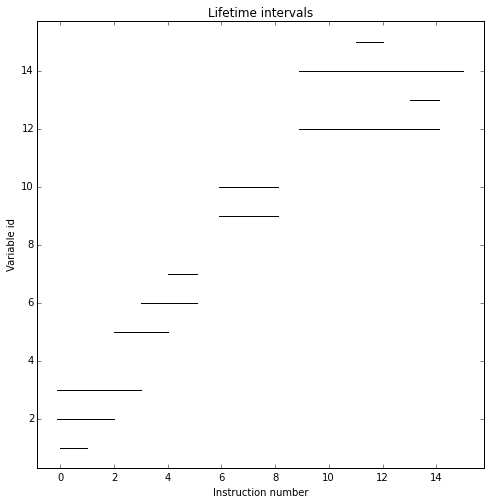

In [4]:
import utils
%matplotlib inline
utils.draw_intervals(intervals, figsize=(8, 8))

All the intervals are black because they don't have any regisers assigned yet.

### Register allocation
Now, let's try to perform register allocation with 2 available registers. The function responsible for allocation takes as input intervals, number of registers and a boolean variable denoting whether we allow spilling or not.
The function returns True if it succeeded to allocate registers to all variables without spilling, and False otherwise.

Allocation succeeded without spilling:  False 

INTERVAL             VAR-ID       REG    
[-0.1, 2]            v2           reg2   
[-0.1, 3]            v3            -     
[0, 1]               v1           reg1   
[2, 4]               v5           reg1   
[3, 5.1]             v6           reg2   
[4, 5.1]             v7           reg1   
[5.9, 8.1]           v10          reg2   
[5.9, 8.1]           v9           reg1   
[8.9, 14.1]          v12          reg2   
[8.9, 15]            v14           -     
[11, 12]             v15          reg1   
[13, 14.1]           v13          reg1   




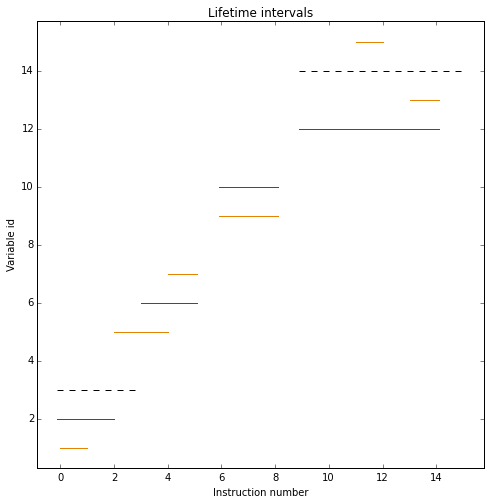

In [5]:
success = bls.allocate_registers(intervals, 2, spilling=True)
print "Allocation succeeded without spilling: ", success, "\n"
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(8, 8))

As we can see, 2 registers are not enough - two variables had to be spilled into memory. In the picture above, intervals with the same color have the same registers assigned. Spilled intervals are distinguished by a dashed line.
In the next step, for each spilled interval (variable), we have to insert \texttt{store} and \texttt{load} instructions in a proper points in the code.

### Spill code insertion
The procedure responsible for inserting spill code is independent from allocation algorithms. It takes the function as the only argument and modifies it accordingly. We can print the result afterwards.

In [6]:
cfg.resolve.insert_spill_code(g)
print FunctionString(g, Opts(mark_spill=True))

bb1(entry)
  0:  v23 = load_ mem(v3)             
  1:   v1 = icmp v2 v23              
  2:   v4 = br v1 bb3 bb2          


bb2(if.then)
  3:  v21 = load_ mem(v3)             
  4:   v5 = xor v2 v21              
  5:  v22 = load_ mem(v3)             
  6:   v6 = xor v22 v5              
  7:   v7 = xor v5 v6               
  8:   v8 = br bb3                 


bb3(if.end)
  9:   v9 = phi bb2 -> v6 bb1 -> v3 
 10:  v10 = phi bb2 -> v7 bb1 -> v2 
 11:  v11 = br bb4                 


bb4(while.cond)
 12:  v12 = phi bb5 -> v13 bb3 -> v9 
 13:  v14 = phi bb5 -> v12 bb3 -> v10 
 14:  v15 = icmp v12 const           
 15:  v16 = br v15 bb6 bb5         


bb5(while.body)
 16:  v20 = load_ mem(v14)            
 17:  v13 = srem v20 v12             
 18:  v17 = br bb4                 


bb6(while.end)
 19:  v19 = load_ mem(v14)            
 20:  v18 = ret v19                 




The inserted \texttt{load} and \texttt{store} instructions are colored in violet. We also add an underscore symbol distinguish them from \texttt{store} and \texttt{load} instructions present in the original code. to Inserting new instructions changes the structure of the CFG, so the data-flow analysis should be repeated. We follow the convention that each procedure modifying the structure of the function is responsible for performing the necessary analysis afterwords. Therefore, we don't have to do it on our own.

### Repeated register allocation
After spilling two variables the register pressure decreased and we can try to repeat the allocation (but we don't allow spilling any more). We build the intervals again and execute the allocation algorithm.

INTERVAL             VAR-ID       REG    
[-0.1, 4]            v2            -     
[0, 1]               v23           -     
[1, 2]               v1            -     
[3, 4]               v21           -     
[4, 7]               v5            -     
[5, 6]               v22           -     
[6, 8.1]             v6            -     
[7, 8.1]             v7            -     
[8.9, 11.1]          v10           -     
[8.9, 11.1]          v9            -     
[11.9, 18.1]         v12           -     
[14, 15]             v15           -     
[16, 17]             v20           -     
[17, 18.1]           v13           -     
[19, 20]             v19           -     




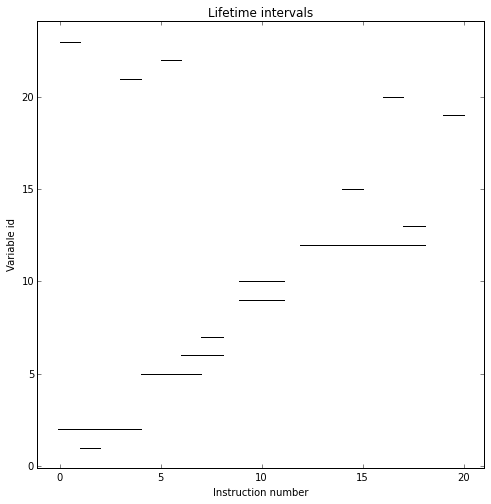

In [7]:
intervals = bls.compute_intervals(g)
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(8, 8))

Allocation succeeded without spilling:  True 

INTERVAL             VAR-ID       REG    
[-0.1, 4]            v2           reg2   
[0, 1]               v23          reg1   
[1, 2]               v1           reg1   
[3, 4]               v21          reg1   
[4, 7]               v5           reg2   
[5, 6]               v22          reg1   
[6, 8.1]             v6           reg1   
[7, 8.1]             v7           reg2   
[8.9, 11.1]          v10          reg1   
[8.9, 11.1]          v9           reg2   
[11.9, 18.1]         v12          reg1   
[14, 15]             v15          reg2   
[16, 17]             v20          reg2   
[17, 18.1]           v13          reg2   
[19, 20]             v19          reg1   




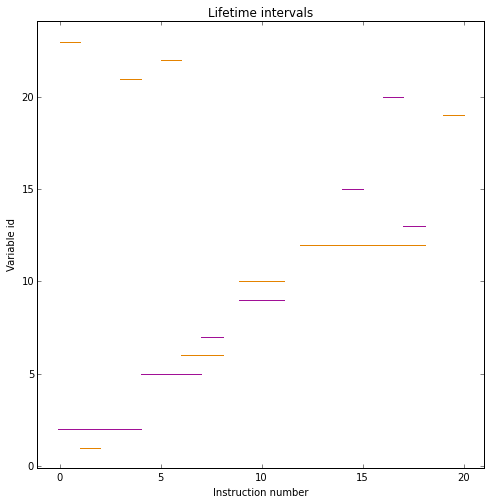

In [8]:
success = bls.allocate_registers(intervals, 2, spilling=False)
print "Allocation succeeded without spilling: ", success, "\n"
print IntervalsString(intervals)
utils.draw_intervals(intervals, regcount=2, figsize=(8, 8))

Now the allocator finished successfully. Let us print out the function with the allocated registers next to the corresponding variables.

In [9]:
print FunctionString(g, Opts(with_alloc=True, liveness=True))

bb1(entry)
  0: v23(reg1) = load_ mem(v3)    
  1: v1(reg1) = icmp v2(reg2) v23(reg1) 
  2:   v4 = br v1(reg1) bb3 bb2 
   LIVE-IN: [(v2, reg2)]
  LIVE-OUT: [(v2, reg2)]


bb2(if.then)
  3: v21(reg1) = load_ mem(v3)    
  4: v5(reg2) = xor v2(reg2) v21(reg1) 
  5: v22(reg1) = load_ mem(v3)    
  6: v6(reg1) = xor v22(reg1) v5(reg2) 
  7: v7(reg2) = xor v5(reg2) v6(reg1) 
  8:   v8 = br bb3                 
   LIVE-IN: [(v2, reg2)]
  LIVE-OUT: [(v6, reg1), (v7, reg2)]


bb3(if.end)
  9: v9(reg2) = phi bb2 -> v6(reg1) bb1 -> v3(mem(v3)) 
 10: v10(reg1) = phi bb2 -> v7(reg2) bb1 -> v2(reg2) 
 11:  v11 = br bb4                 
   LIVE-IN: [(v9, reg2), (v10, reg1)]
  LIVE-OUT: [(v9, reg2), (v10, reg1)]


bb4(while.cond)
 12: v12(reg1) = phi bb5 -> v13(reg2) bb3 -> v9(reg2) 
 13: v14(mem(v14)) = phi bb5 -> v12(reg1) bb3 -> v10(reg1) 
 14: v15(reg2) = icmp v12(reg1) const 
 15:  v16 = br v15(reg2) bb6 bb5 
   LIVE-IN: [(v12, reg1)]
  LIVE-OUT: [(v12, reg1)]


bb5(while.body)
 16: v20(reg2) =

### Translating out of SSA form
The last thing we have to do is to translate the program out of SSA form. Alike the spill code insertion, $\phi$-elimination is also independent from the allocation algorithm. However, if there are memory-to-memory copies or mov cycles, it can create additional variables which need a regsiter. Therefore, apart from the function instance, we also pass in the argument the total number of available registers. It returns True on success and False otherwise.

In [10]:
success = cfg.resolve.eliminate_phi(g, 2)
print "Phi elimination succeeded: ", success, "\n"
print FunctionString(g, Opts(with_alloc=True))

Phi elimination succeeded:  True 

bb1(entry)
  0: v23(reg1) = load_ mem(v3)    
  1: v1(reg1) = icmp v2(reg2) v23(reg1) 
  2:   v4 = br v1(reg1) bb3 bb2 


bb2(if.then)
  3: v21(reg1) = load_ mem(v3)    
  4: v5(reg2) = xor v2(reg2) v21(reg1) 
  5: v22(reg1) = load_ mem(v3)    
  6: v6(reg1) = xor v22(reg1) v5(reg2) 
  7: v7(reg2) = xor v5(reg2) v6(reg1) 
  8: store_ mem(v24) v6(reg1) 
  9: v10(reg1) = mov v7(reg2)   
 10: v9(reg2) = load_ mem(v24)   
 11:   v8 = br bb3                 


bb7(None)
 12: v10(reg1) = mov v2(reg2)   
 13: v9(reg2) = load_ mem(v3)    
 14: br bb3                 


bb3(if.end)
 15: store_ mem(v14) v10(reg1) 
 16: v12(reg1) = mov v9(reg2)   
 17:  v11 = br bb4                 


bb4(while.cond)
 18: v15(reg2) = icmp v12(reg1) const 
 19:  v16 = br v15(reg2) bb6 bb5 


bb5(while.body)
 20: v20(reg2) = load_ mem(v14)   
 21: v13(reg2) = srem v20(reg2) v12(reg1) 
 22: store_ mem(v14) v12(reg1) 
 23: v12(reg1) = mov v13(reg2)  
 24:  v17 = br bb4              

On the listing above we can see all the moves generated by phi elimination, even those between variables sharing the same register. We can also notice a new basic block - \textit{bb7}, created on the edge between blocks \textit{bb1} and \textit{bb3}, which had to be inserted because of \textit{bb1} having multiple successors. When we print the function with \texttt{alloc\_only=True} option, registers are showed instead of variables and redundant instructions or basic blocks are skipped. By setting \texttt{mark\_non\_ssa=True} we will see instructions produced by the $\phi$-elimination phase colored violet. The variables that stayed yellow are those which are not used anywhere in the program, hence don't need a register.

In [11]:
print FunctionString(g, Opts(alloc_only=True, mark_non_ssa=True))

bb1(entry)
  0: reg1 = load_ mem(v3)    
  1: reg1 = icmp reg2 reg1 
  2:   v4 = br reg1 bb3 bb2 


bb2(if.then)
  3: reg1 = load_ mem(v3)    
  4: reg2 = xor reg2 reg1 
  5: reg1 = load_ mem(v3)    
  6: reg1 = xor reg1 reg2 
  7: reg2 = xor reg2 reg1 
  8: store_ mem(v24) reg1 
  9: reg1 = mov reg2       
 10: reg2 = load_ mem(v24)   
 11:   v8 = br bb3                 


bb7(None)
 12: reg1 = mov reg2       
 13: reg2 = load_ mem(v3)    
 14: br bb3                 


bb3(if.end)
 15: store_ mem(v14) reg1 
 16: reg1 = mov reg2       
 17:  v11 = br bb4                 


bb4(while.cond)
 18: reg2 = icmp reg1 const 
 19:  v16 = br reg2 bb6 bb5 


bb5(while.body)
 20: reg2 = load_ mem(v14)   
 21: reg2 = srem reg2 reg1 
 22: store_ mem(v14) reg1 
 23: reg1 = mov reg2       
 24:  v17 = br bb4                 


bb6(while.end)
 25: reg1 = load_ mem(v14)   
 26:  v18 = ret reg1       




# Correctness
After successful allocation we may want to check if the allocation, as well as data-flow are correct. We do it by using \texttt{cfg.sanity} module:

In [12]:
import cfg.sanity as sanity
print "Allocation is correct: ", sanity.allocation_is_correct(g)
print "Data flow is correct: ", sanity.data_flow_is_correct(g, gcd)

Allocation is correct:  True
Data flow is correct:  True


# Cost of the allocation

At the end we can calculate the cost of the register allocation. Our main cost calculator depends on 3 parameters: $S$, $N$ and $L$ meaning respectively: the cost of spill instructions, the cost of normal instructions and the loop penalty. The final cost of the allocation is a difference between the modified and the original function costs. Here, we can also print out the detailed view of the cost computation by using \texttt{cfg.printer.CostString} .

In [13]:
from cost import MainCostCalculator
from cfg.printer import CostString

mcc = MainCostCalculator()
print CostString(g, mcc), "\n"

print "Final cost of the allocation: ", mcc.function_diff(g, gcd)

Main cost (S=2, N=1, L=10)
  LOOP     COST               INSTR             
   0       2.0      0: reg1 = load_ mem(v3)    
   0       1.0      1: reg1 = icmp reg2 reg1 
   0       1.0      2:   v4 = br reg1 bb3 bb2 
   0       2.0      3: reg1 = load_ mem(v3)    
   0       1.0      4: reg2 = xor reg2 reg1 
   0       2.0      5: reg1 = load_ mem(v3)    
   0       1.0      6: reg1 = xor reg1 reg2 
   0       1.0      7: reg2 = xor reg2 reg1 
   0       2.0      8: store_ mem(v24) reg1 
   0       1.0      9: reg1 = mov reg2       
   0       2.0     10: reg2 = load_ mem(v24)   
   0       1.0     11:   v8 = br bb3                 
   0       1.0     12: reg1 = mov reg2       
   0       2.0     13: reg2 = load_ mem(v3)    
   0       1.0     14: br bb3                 
   0       2.0     15: store_ mem(v14) reg1 
   0       1.0     16: reg1 = mov reg2       
   0       1.0     17:  v11 = br bb4                 
   1       10.0    18: reg2 = icmp reg1 const 
   1       10.0    19:  v1

From the listing above, we can easily see which instructions increased the cost significantly. These are especially load and store instructions situated in a loop. 

## Full register allocation
After the step-by-step introduction we show how to take advantage of the general register allocation procedure. It takes a function instance and a number of available registers. On success it returns a modified copy of the input function. It is already after phi elimination phase. On failure, however, None is returned.

In [14]:
h = bls.perform_full_register_allocation(gcd, 2)
if h:
    print "Allocation succeeded"
    print "Cost: ", mcc.function_diff(h, gcd)

Allocation succeeded
Cost:  70.0


## Comparing different algorithms
It is very easy to compare allocation algorithms. To do that, we use \texttt{utils.ResultCompSetting} class which in constructor takes lists of functions, regcounts (different numbers of registers), allocation algorithms (allocators) and cost calculators. Then, it is passed to \texttt{utils.compute\_full\_results} which runs all provided algorithms on all the functions with all given numbers of registers and calculates cost with each provided calculator. It returns a four-time list composition with all possible results, which can be printed out by \texttt{utils.compute\_and\_print\_result\_table(result, setting)}.

For example, we will compare two spilling heuristics of basic linear scan algorithm - the "furthest first" strategy, which chooses to spill the interval with the furthest end and "current first", which always spills the current interval.

In [15]:
import allocators.lscan.basic.spillers as spillers
from cost import MainCostCalculator

# Allocators
basic_ff = BasicLinearScan(name="basic furthest first")
basic_cf = BasicLinearScan(spiller=spillers.CurrentFirst(), name="basic current first")

# Cost calculator
mcc = MainCostCalculator()

# Setup
setting = utils.ResultCompSetting(
    inputs = m.functions.values(), # We take all the functions from the module
    regcounts = [1, 2, 3, 4, 5], 
    allocators = [basic_ff, basic_cf], 
    cost_calculators = [mcc])

print "Comparing \'furthest first\' and \'current first\' strategies."
results = utils.compute_full_results(setting)
utils.compute_and_print_result_table(results, setting)
print "\n"

Comparing 'furthest first' and 'current first' strategies.
+-------------------+----------------------------+----------------------------+
|                   | basic furthest first       | basic current first        |
+-------+-----------+----------------------------+----------------------------+
| Input | Registers | Main cost (S=2, N=1, L=10) | Main cost (S=2, N=1, L=10) |
+-------+-----------+----------------------------+----------------------------+
| main  | 1         | Failed                     | Failed                     |
|       +-----------+----------------------------+----------------------------+
|       | 2         | 84.0                       | 204.0                      |
|       +-----------+----------------------------+----------------------------+
|       | 3         | 42.0                       | 162.0                      |
|       +-----------+----------------------------+----------------------------+
|       | 4         | 0.0                        | 0.0       

It is clear that the \textit{Current-First} strategy is much worse than the \texttt{Furthest-First}. Small costs for higher register numbers are caused by additional \texttt{mov}-instructions inserted in the $\phi$-elimination phase.

## Regcount-to-cost plot
Another feature we may use is to plot how the cost is changing with the number of available registers.
This time, we fill use \texttt{SpillInstructionsCounter} instead of \texttt{MainCostCalculator} to check how fast the number of spill code decreases when we add more registers. To make the test more interesting, we will use larger program - Fast Fourier Transform (\texttt{fft.json}). As before, we have to compute the results passing an appropriate settings object.

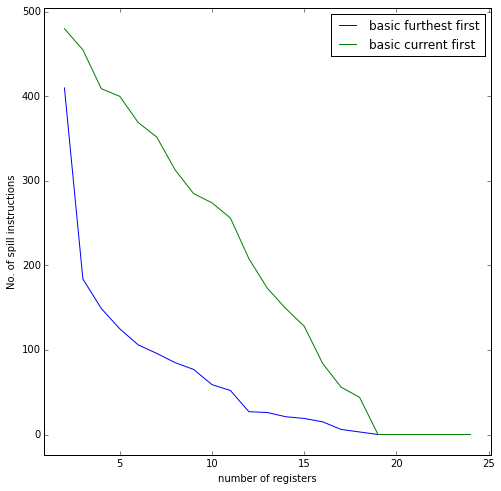

In [16]:
from cost import SpillInstructionsCounter
sic = SpillInstructionsCounter()

m = cfg.Module.from_file("programs/fft.json")
analysis.perform_full_analysis(m)

setting = utils.ResultCompSetting(
    inputs = m.functions.values(), # We take all the functions from the module
    regcounts = range(1, 25), 
    allocators = [basic_ff, basic_cf], 
    cost_calculators = [sic])

results = utils.compute_full_results(setting)
utils.plot_reg_to_cost(results, setting, figsize=(8, 8))

At the point $(x,y)$ in the plot corresponding to a particular algorithm, $y$ is the sum of costs for all functions in the module calculated after executing the algorithm on each function with $x$ free registers. The plot is cut for the first register numbers if there was at least one function for which the algorithm failed. Here, algorithm succeeded for all functions just with 2 registers.